## Try a simplist vae on midi data

In [2]:
import os
import pretty_midi
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame

os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'


pygame 2.6.1 (SDL 2.28.4, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# load data
# path = "../../dataset/midi_dataset/filtered_midi_imgs_small.npy"
path = "../../dataset/quickdraw_dataset/eye_100.npy"
midi_data = np.load(path, allow_pickle=True,)
print(f"Loaded {len(midi_data)} midi files from {path}")
print(f"Shape of midi data: {midi_data.shape}")



Loaded 43501 midi files from ../../dataset/quickdraw_dataset/eye_100.npy
Shape of midi data: (43501, 100, 100)


Batch shape: torch.Size([256, 100, 100])


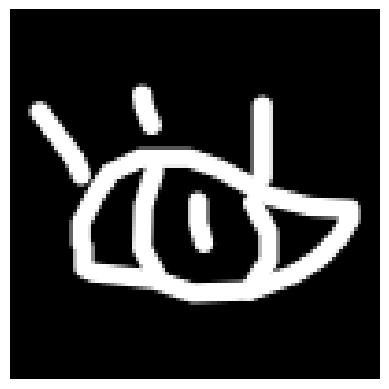

In [4]:
# make dataset 
import torch
from torch.utils.data import Dataset, DataLoader

picked_num = 43501
picked_midi = midi_data[:picked_num]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MidiDataset(Dataset):
    def __init__(self, midi_data):
        self.midi_data = midi_data

    def __len__(self):
        return len(self.midi_data)

    def __getitem__(self, idx):
        midi_file = self.midi_data[idx]
        return midi_file
# Create a dataset and dataloader
midi_dataset = MidiDataset(picked_midi)
midi_dataloader = DataLoader(midi_dataset, batch_size=256, shuffle=True)
# Check the shape of the data
for batch in midi_dataloader:
    print(f"Batch shape: {batch.shape}")
    break
# Visualize the data
def visualize_midi(midi_file):
    midi_file = midi_file.reshape(100, 100)  # Reshape to 28x28 for visualization
    plt.imshow(midi_file, cmap='gray')
    plt.axis('off')
    plt.show()
# Visualize a random midi file
random_idx = random.randint(0, len(midi_data) - 1)
midi_file = midi_data[random_idx]
visualize_midi(midi_file)


## Linear

In [24]:

# write a simplest vae model
from torch import nn
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2)  # output mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # std = torch.exp(0.5 * logvar)
        std = logvar
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Convolutional

In [19]:

## Convlutional
from torch import nn
class ConvVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Unflatten(1, (1, input_dim, input_dim)),
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=5, padding=0),
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2)  # output mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 128 * 5 * 5),
            nn.ReLU(),
            nn.Unflatten(1, (128, 5, 5)),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=5, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid(),
            nn.Upsample(size=(input_dim, input_dim), mode='nearest')
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [28]:
def compute_loss(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x.flatten(1), x, reduction='sum')
    # BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # std = logvar
    # KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu.pow(2) - std**2)
    return BCE + KLD* beta, BCE, KLD

In [29]:
def train(model, dataloader, optimizer, epochs=10, beta = 1):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            # print(f"min batch: {batch.min()}, max batch: {batch.max()}")
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss, bce, kld = compute_loss(recon_batch, batch, mu, logvar, beta)
            loss.backward()
            train_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}, \
                  BCE: {bce_loss / len(dataloader.dataset)}, KLD: {kld_loss / len(dataloader.dataset)}")
        # print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}")

In [ ]:
input_dim = 100  # Assuming the input is a flattened 100x100 image
hidden_dim = 1024
latent_dim = 256

model = ConvVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [79]:
train(model, midi_dataloader, optimizer, epochs=50, beta = 1)
# save the model

model_path = "simpest_vae_model_quickdraw.pth"
torch.save(model.state_dict(), model_path)

Epoch 1, Loss: 1320.4574557194087,                   BCE: 1226.6494800406888, KLD: 93.80797343380037
Epoch 11, Loss: 1305.2551414047953,                   BCE: 1211.1078222339715, KLD: 94.14732056267384
Epoch 21, Loss: 1289.949162088228,                   BCE: 1195.3500386485368, KLD: 94.59912070088906
Epoch 31, Loss: 1280.5344683168203,                   BCE: 1185.624814659433, KLD: 94.90965172675628
Epoch 41, Loss: 1267.2237491666858,                   BCE: 1172.0556869382312, KLD: 95.16805755902163


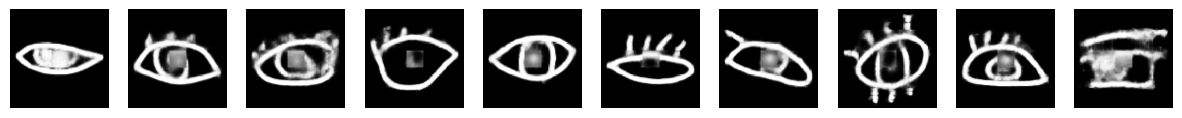

In [ ]:
# reconstruct some images
def reconstruct_images(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            recon_batch, mu, logvar = model(batch)
            recon_batch = recon_batch.view(-1, 1, 100, 100).cpu().numpy()
            break
    return recon_batch[:num_images], batch[:num_images].view(-1, 1, 100, 100).cpu().numpy()
# Visualize the reconstructed images
def visualize_reconstructed_images(recon_images):
    fig, axes = plt.subplots(1, len(recon_images), figsize=(15, 5))
    for i, img in enumerate(recon_images):
        axes[i].imshow(img[0], cmap='gray')
        axes[i].axis('off')
    plt.show()
recon_images, ori_images = reconstruct_images(model, midi_dataloader, num_images=10)
visualize_reconstructed_images(ori_images)
visualize_reconstructed_images(recon_images)


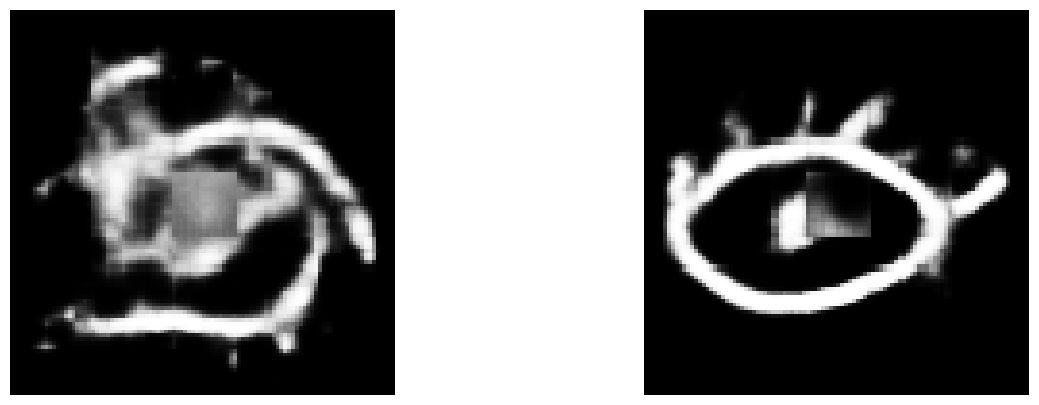

In [99]:
# sample from the model
def generate_sample(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device) 
        samples = model.decode(z).cpu()
        return samples
    
# visualize the samples
def visualize_samples(samples):
    samples = samples.view(-1, 100, 100)  # Reshape to original dimensions
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for i, sample in enumerate(samples):
        axes[i].imshow(sample.cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show() 
    
visualize_samples(generate_sample(model, num_samples=2))

Saved sample_0.mid
Saved sample_1.mid
Saved sample_2.mid
Saved sample_3.mid
Saved sample_4.mid
Saved sample_5.mid
Saved sample_6.mid
Saved sample_7.mid
Saved sample_8.mid
Saved sample_9.mid


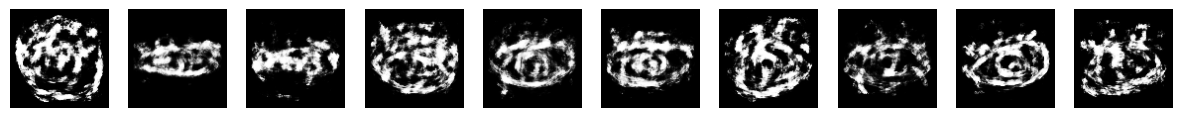

In [41]:
from midi2img import img2midi

samples = generate_sample(model, num_samples=10)
for i, sample in enumerate(samples):
    sample = sample.view(100, 100).cpu().numpy()
    midi_file = img2midi(sample)
    midi_file.write(f"sample_{i}.mid")
    print(f"Saved sample_{i}.mid")
    
visualize_samples(samples)
